In [1]:
# -*- coding: utf-8 -*-
"""Triplet_Loss_And_Generator.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1QHxHqwoBufR0tAYPyDcAi_Cf1AMlG6Fo
"""

import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import pickle
import tensorflow_hub as hub
import random
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import InceptionV3

!rm -rf /content/.cache && rm -rf /tmp/*
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp /content/drive/MyDrive/FaceData/data_test.pkl /content
!cp /content/drive/MyDrive/FaceData/data_train.pkl /content

drive.flush_and_unmount()

In [3]:
import pickle
import numpy as np
with open('data_test.pkl', 'rb') as f:
    test_df = pickle.load(f)

with open('data_train.pkl', 'rb') as f:
    train_df = pickle.load(f)

x_train = train_df['image']
y_train = train_df['person']

x_test = test_df['image']
y_test = test_df['person']

def remove_extra_dim(image):
    try:
        return np.squeeze(image, axis=0)  # Efficient removal if size 1
    except ValueError:
        # Extra dimension not found, return the original data
        print('failed')
        return image

# Loop through each image in the Series
for index, image in x_train.items():  # Access elements using items()
    x_train.loc[index] = remove_extra_dim(image)  # Modify Series in-place

for index, image in x_test.items():  # Access elements using items()
    x_test.loc[index] = remove_extra_dim(image)  # Modify Series in-place

x_train[0].shape

x_train.shape

classes = set()
for i in y_train:
  classes.add(i)

classes = list(classes)
classes

def data_generator(batch_size=64):
  while True:
    a = []
    p = []
    n = []
    for _ in range(batch_size):
      found = True
      while(found):
        pos_neg = random.sample(classes, 2)
        try:
          positive_samples = random.sample(list (x_train [y_train==pos_neg [0]]), 2)
          negative_sample= random.choice(list (x_train [y_train == pos_neg [1]]))
          found = False
        except:
          continue
      a.append(positive_samples [0])
      p.append(positive_samples [1])
      n.append(negative_sample)

    yield ([np.array(a), np.array(p), np.array(n)], np.zeros((batch_size, 1)).astype("float32"))

def triplet_loss (y_true, y_pred):
  anchor_out = y_pred[:, 0:128]
  positive_out = y_pred[:, 128:256]
  negative_out = y_pred[:, 256:384]
  pos_dist = K.sum(K.abs(anchor_out-positive_out), axis=1)
  neg_dist = K.sum(K.abs(anchor_out - negative_out), axis=1)
  stacked_distances = K.stack([pos_dist, neg_dist], axis=0)
  probs = K.softmax(stacked_distances, axis=0)
  return K.mean(K.abs (probs [0]) + K.abs (1.0 - probs [1]))

input_shape = (224,224,3);
input_layer = layers.Input(shape=input_shape)
inception = InceptionV3(weights='imagenet', include_top=False)
feature_extractor = inception(input_layer)
for layer in inception.layers:
    layer.trainable = False
gap_layer = layers.GlobalAveragePooling2D()(feature_extractor)
fc_layer = layers.Dense(128, activation='relu')(gap_layer)
l2_norm_layer = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(fc_layer)
model = Model(inputs=input_layer, outputs=l2_norm_layer)

model.summary()

triplet_model_a = layers.Input((224, 224, 3))
triplet_model_p = layers.Input((224, 224, 3))
triplet_model_n = layers.Input((224, 224, 3))
triplet_model_out = layers.Concatenate()([model (triplet_model_a), model (triplet_model_p), model(triplet_model_n)])
triplet_model = Model( [triplet_model_a, triplet_model_p, triplet_model_n], triplet_model_out)
# triplet_model.summary()

my_optimizer = keras.optimizers.Adam(0.0005)

triplet_model.compile(loss=triplet_loss, optimizer=my_optimizer)

triplet_model.fit_generator(data_generator(),steps_per_epoch=87,epochs=5)



87910968/87910968 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048   21802784  
                             )                                   
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 lambda (Lambda)             (None, 128)               0         
                                                              

<ipython-input-3-7bda5ded605c>:96: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  triplet_model.fit_generator(data_generator(),steps_per_epoch=87,epochs=5)


Epoch 1/5
87/87 [==============================] - 73s 401ms/step - loss: 0.5061
Epoch 2/5
87/87 [==============================] - 36s 412ms/step - loss: 0.4026
Epoch 3/5
87/87 [==============================] - 37s 420ms/step - loss: 0.3490
Epoch 4/5
87/87 [==============================] - 38s 432ms/step - loss: 0.3232
Epoch 5/5
87/87 [==============================] - 38s 433ms/step - loss: 0.3060


In [4]:
model_path = "/content"

In [5]:
tf.keras.models.save_model(triplet_model,model_path)

In [6]:
triplet_model.save('facenetep5.h5',save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!cp /content/facenetv2.h5 /content/drive/MyDrive

cp: cannot stat '/content/facenetv2.h5': No such file or directory


In [12]:
!mkdir FaceNet

In [14]:
!mkdir FaceNet/variables


In [15]:
!cp /content/fingerprint.pb /content/FaceNet
!cp /content/keras_metadata.pb /content/FaceNet
!cp /content/saved_model.pb /content/FaceNet

In [16]:
!cp /content/variables/variables.data-00000-of-00001 /content/FaceNet/variables
!cp /content/variables/variables.index /content/FaceNet/variables

In [17]:
import os
from zipfile import ZipFile
with ZipFile("FaceNetep5.zip",'w') as zip_file:
  for root,_,files in os.walk('/content/FaceNet'):
    for filer in files:
      filepath = os.path.join(root,filer)
      zip_file.write(filepath,os.path.relpath(filepath,'/content/FaceNetep5'))

print('success!')

success!


In [18]:
!cp /content/FaceNetep5.zip /content/drive/MyDrive

In [21]:
!cp /content/drive/MyDrive/FaceNet.zip /content

In [22]:
drive.flush_and_unmount()

In [ ]:
!unzip FaceNet.zip

Archive:  FaceNet.zip
 extracting: fingerprint.pb          
 extracting: saved_model.pb          
 extracting: keras_metadata.pb       
 extracting: variables/variables.data-00000-of-00001  
 extracting: variables/variables.index  


In [33]:
from keras.models import load_model

# def triplet_loss (y_true, y_pred):
#   anchor_out = y_pred[:, 0:128]
#   positive_out = y_pred[:, 128:256]
#   negative_out = y_pred[:, 256:384]
#   pos_dist = K.sum(K.abs(anchor_out-positive_out), axis=1)
#   neg_dist = K.sum(K.abs(anchor_out - negative_out), axis=1)
#   stacked_distances = K.stack([pos_dist, neg_dist], axis=0)
#   probs = K.softmax(stacked_distances, axis=0)
#   return K.mean(K.abs (probs [0]) + K.abs (1.0 - probs [1]))

# Load the model with custom loss function
model = load_model('/content/FaceNet', custom_objects={'triplet_loss': triplet_loss})

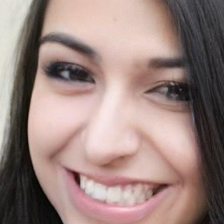

(1, 224, 224, 3)

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
face_classifier = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')
path_of_img = "/content/IMG-20240411-WA0018.jpg"
image = cv2.imread(path_of_img)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
(x, y, w, h) = face_classifier.detectMultiScale(gray, 1.3, 5)[0]
image = image[y:y+h, x:x+w, :]
img = cv2.resize(image, (224, 224))
cv2_imshow(img)
img = np.asarray(img)
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)
img.shape

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 model (Functional)          (None, 128)                  2206505   ['input_3[0][0]',             
                                                          6          'input_4[0][0]',       

In [ ]:

single_image_input = layers.Input(shape=(224, 224, 3), name='single_image_input')
embedding_output = model.layers[3](single_image_input)
inference_model = Model(inputs = single_image_input, outputs = embedding_output)
inference_model.set_weights(model.get_weights())

In [ ]:
inference_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 single_image_input (InputL  [(None, 244, 244, 3)]     0         
 ayer)                                                           
                                                                 
 model (Functional)          (None, 128)               22065056  
                                                                 
Total params: 22065056 (84.17 MB)
Trainable params: 262272 (1.00 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [ ]:
embedding = inference_model.predict(img)

1/1 [==============================] - 2s 2s/step


In [ ]:
print(embedding)

[[0.         0.         0.         0.04042253 0.         0.
  0.         0.29145983 0.10728847 0.         0.09610736 0.
  0.02554324 0.0235552  0.27052015 0.         0.         0.
  0.24015969 0.         0.14421701 0.00376605 0.         0.
  0.         0.07003427 0.00144916 0.         0.06063971 0.
  0.13238344 0.         0.13622816 0.         0.06872657 0.
  0.         0.         0.         0.         0.         0.19209976
  0.         0.01623704 0.20732313 0.         0.         0.202524
  0.11044134 0.08241065 0.         0.07500924 0.         0.06060442
  0.         0.         0.0595653  0.         0.09179811 0.08228955
  0.09223853 0.07326786 0.         0.         0.         0.
  0.         0.         0.         0.         0.01102137 0.04342299
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.19482674 0.
  0.         0.         0.         0.         0.         0.
  0.19386308 0.         0.1340514  0.30371094 0.         0.067

In [ ]:
embedding.shape

(1, 5, 5, 2048)

In [ ]:
!pip install keras_facenet
from keras_facenet import FaceNet
Perfect_model = FaceNet()

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 6.9 MB/s eta 0:00:00
  Created wheel for keras_facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10369 sha256=b16f2458840dbbd74edccc3c68f0e6c7a8f3f7327b1389fd72812d911a4df9ff
  Stored in directory: /root/.cache/pip/wheels/1d/d8/a9/85cf04ea29321d2afcb82c0caaafdca9195385f9d68cbc7185
Successfully built keras_facenet


In [ ]:
embed = Perfect_model.embeddings(img)
embed.shape

1/1 [==============================] - 0s 191ms/step


(1, 512)

In [ ]:
embedding[0]

array([0.        , 0.        , 0.        , 0.04042253, 0.        ,
       0.        , 0.        , 0.29145983, 0.10728847, 0.        ,
       0.09610736, 0.        , 0.02554324, 0.0235552 , 0.27052015,
       0.        , 0.        , 0.        , 0.24015969, 0.        ,
       0.14421701, 0.00376605, 0.        , 0.        , 0.        ,
       0.07003427, 0.00144916, 0.        , 0.06063971, 0.        ,
       0.13238344, 0.        , 0.13622816, 0.        , 0.06872657,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.19209976, 0.        , 0.01623704, 0.20732313,
       0.        , 0.        , 0.202524  , 0.11044134, 0.08241065,
       0.        , 0.07500924, 0.        , 0.06060442, 0.        ,
       0.        , 0.0595653 , 0.        , 0.09179811, 0.08228955,
       0.09223853, 0.07326786, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01102137, 0.04342299, 0.        , 0.        , 0.     

In [ ]:
ssr = 0
for i in range(128):
  ssr = ssr + ((embedding[0][i]-embed[0][i])**2)
ssr

1.1862174341266216

enter: Aviral
image: who.jpg


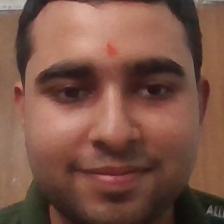

1/1 [==============================] - 0s 129ms/step
enter: Vaibhav Sharma
image: jeff.jpg


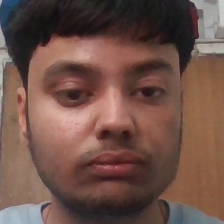

1/1 [==============================] - 0s 137ms/step
enter: Ashish
image: ashish.jpg


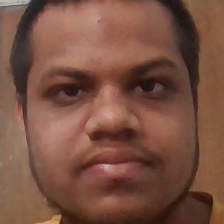

1/1 [==============================] - 0s 143ms/step
enter: Vaibhav Chaudhary
image: test6.jpg


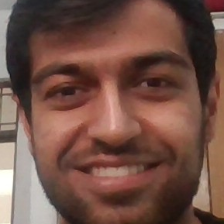

1/1 [==============================] - 0s 137ms/step


In [ ]:
import pickle

data = []
for i in range(4):
  name = input('enter: ')
  path = input('image: ')
  face_classifier = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')
  path_of_img = path
  image = cv2.imread(path_of_img)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  (x, y, w, h) = face_classifier.detectMultiScale(gray, 1.3, 5)[0]
  image = image[y:y+h, x:x+w, :]
  img = cv2.resize(image, (224, 224))
  cv2_imshow(img)
  img = np.asarray(img)
  img = img.astype('float32') / 255.0
  img = np.expand_dims(img, axis=0)
  img.shape
  embedd = inference_model.predict(img)
  embedd = embedd[0]
  data.append((name, embedd))

with open("data.pkl", "wb") as f:
    pickle.dump(data, f)


image: h.png


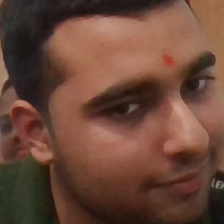

1/1 [==============================] - 0s 134ms/step
Predicted class name for the new image: Aviral


In [ ]:

import pickle
import numpy

with open("data.pkl", "rb") as f:
    data = pickle.load(f)

class_name_and_arrays = data

path = input('image: ')
face_classifier = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')
path_of_img = path
image = cv2.imread(path_of_img)
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# (x, y, w, h) = face_classifier.detectMultiScale(gray, 1.3, 5)[0]
# image = image[y:y+h, x:x+w, :]
img = cv2.resize(image, (224, 224))
cv2_imshow(img)
img = np.asarray(img)
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)
img.shape
new_embedding = inference_model.predict(img)

highest_similarity = -float('inf')  # Initialize with a negative infinity
predicted_class_name = None
for class_name, array in class_name_and_arrays:
    similarity = numpy.dot(new_embedding, array) / (numpy.linalg.norm(new_embedding) + numpy.linalg.norm(array))  # Calculate similarity
    if similarity > highest_similarity:
        highest_similarity = similarity
        predicted_class_name = class_name

print(f"Predicted class name for the new image: {predicted_class_name}")